# Regional Weather Forcast with ANN

### External Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr

# for ML
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Basic data

In [2]:
lat_target=45.0
lon_target=360-117.0

In [3]:
pathname = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_huss_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_daily.nc'

In [4]:
filehandle=Dataset(pathname,'r',format="NETCDF4")
lathandle=filehandle.variables['lat']
lonhandle=filehandle.variables['lon']
timehandle=filehandle.variables['time']
datahandle=filehandle.variables['specific_humidity']

In [5]:
time_num=365
timeindex=range(0,time_num,1)
time=timehandle[timeindex]
lat = lathandle[:]
lon = lonhandle[:]

In [6]:
#find indices of target lat/lon/day
lat_index = (np.abs(lat-lat_target)).argmin()
lon_index = (np.abs(lon-lon_target)).argmin()
#check final is in right bounds
if(lat[lat_index]>lat_target):
	if(lat_index!=0):
		lat_index = lat_index - 1
if(lat[lat_index]<lat_target):
	if(lat_index!=len(lat)):
		lat_index =lat_index +1
if(lon[lon_index]>lon_target):
	if(lon_index!=0):
		lon_index = lon_index - 1
if(lon[lon_index]<lon_target):
	if(lon_index!=len(lon)):
		lon_index = lon_index + 1
lat=lat[lat_index]
lon=lon[lon_index]

In [7]:
data = datahandle[timeindex,lat_index,lon_index]

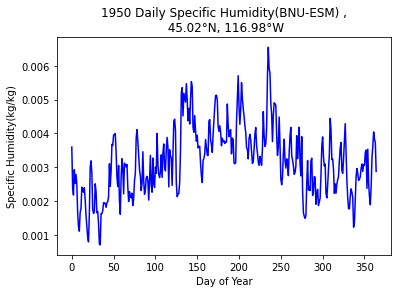

In [8]:
days = np.arange(0,len(time))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(u'Day of Year')
ax.set_ylabel(u'Specific Humidity(kg/kg)')
ax.set_title(u'1950 Daily Specific Humidity(BNU-ESM) ,\n %4.2f\u00b0N, %4.2f\u00b0W' % (lat, abs(360-lon)))
ax.ticklabel_format(style='plain')
ax.plot(days,data,'b-')
plt.savefig("myPythonGraph.png")
plt.show()

### Advanced data

In [9]:
#This script extracts a time series of data from the MACAv2-METDATA dataset from 1950-2099 for a single model, 
#but is easily generalizable to all models, all variables by looping over the models/variables in VARNAME, MODELNAME and 
#over a set of point locations by looping over LAT_TARGETS
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
dirPath='http://thredds.northwestknowledge.net:8080/thredds/dodsC/'  
VARNAME =('tasmax','tasmin','rhsmax','rhsmin','pr','rsds','uas','vas','huss')
VARLONGNAME=('air_temperature','air_temperature', 'relative_humidity','relative_humidity',\
                'precipitation','surface_downwelling_shortwave_flux_in_air',\
                'eastward_wind','northward_wind','specific_humidity')
MODELNAME=('bcc-csm1-1','bcc-csm1-1-m','BNU-ESM','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0',\
            'GFDL-ESM2G','GFDL-ESM2M','HadGEM2-CC365','HadGEM2-ES365',\
                'inmcm4','IPSL-CM5A-MR','IPSL-CM5A-LR','IPSL-CM5B-LR',\
                'MIROC5','MIROC-ESM','MIROC-ESM-CHEM','MRI-CGCM3','NorESM1-M')
SCENNAME =('historical','rcp45','rcp85') 
YEAR_START=('1950','2006','2006')
YEAR_END =('2005','2099','2099')
RUN_NUM=[1] * 20
RUN_NUM[4] = 6 #setting CCSM4 with run 6
DOMAIN='CONUS'

#lat/lon pairs for point locations
LAT_TARGETS=[46.7317]
LON_TARGETS=[116.9972]
#=========================================================

### Imported Data

In [10]:
# Fucntion for reading datasets
def read_file(file):
    df = pd.read_csv(file, sep=',',header=0, encoding='unicode_escape')
    return df

# Encode date to the number of days from 1/1/2020
def encode_date(df):
    return (pd.to_datetime(df['date']).rsub(pd.Timestamp('2006/1/1')).dt.days)*(-1)

In [12]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

path = os.path.join(os.getcwd(), "drive", "My Drive", "Regional-Climate-Forecast-with-ANN")

Mounted at /content/drive


In [15]:
df_his_daily = read_file(os.path.join(path, 'MACA_41.9795 Latitude, -76.9813 Longitude_2006-2019.csv'))
df_cur_daily = read_file(os.path.join(path,'MACA_41.9795 Latitude, -76.9813 Longitude_2019-2020.csv'))
df_future_daily = read_file(os.path.join(path,'MACA_41.9795 Latitude, -76.9813 Longitude_2020-2021.csv'))
df_his_daily['date'] = encode_date(df_his_daily)

In [16]:
df_his_daily

,date,Daily Minimum Near-Surface Air Temperature(K),Daily Maximum Near-Surface Air Temperature(K),Daily Mean Near-Surface Specific Humidity(kgkg-1),vpd(kPa),Precipitation(mm)
0,0,283.398926,293.986755,0.009150,0.47,1.098970
1,1,279.793610,291.428253,0.007570,0.39,1.960552
2,2,275.975372,283.474060,0.003914,0.40,8.333006
3,3,269.891174,278.239380,0.003576,0.13,8.629661
4,4,264.457336,271.953064,0.001893,0.15,0.496073
...,...,...,...,...,...,...
5108,5108,259.946259,274.224274,0.002993,0.00,16.193007
5109,5109,263.408539,273.130951,0.002028,0.14,0.330193
5110,5110,266.284546,278.643951,0.002051,0.32,0.000000
5111,5111,270.068085,280.283051,0.002948,0.30,0.000000


In [17]:
df_his_precipitation = df_his_daily[['date','Precipitation(mm)']]
df_his_max_temp = df_his_daily[['date','Daily Maximum Near-Surface Air Temperature(K)']]

In [18]:
print(sum(df_his_precipitation['Precipitation(mm)'] == 0))
print(sum(df_his_max_temp['Daily Maximum Near-Surface Air Temperature(K)'] == 0))

2620
0


In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(df_his_precipitation)

### Feature Engineering

In [20]:
# functions for visualizing numerical data distributions
def check_distribution_conti(dtf, x):
    fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
    fig.suptitle(x, fontsize=20)
    ### distribution
    ax[0].title.set_text('distribution')
    variable = dtf[x].fillna(dtf[x].mean())
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
    variable = variable[ (variable > breaks[0]) & (variable < 
                        breaks[10]) ]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
    des = dtf[x].describe()
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
    ### boxplot 
    ax[1].title.set_text('outliers (log scale)')
    tmp_dtf = pd.DataFrame(dtf[x])
    tmp_dtf[x] = np.log(tmp_dtf[x])
    tmp_dtf.boxplot(column=x, ax=ax[1])
    plt.show()

# functions for visualizing categorical data distributions
def check_distribution_cat(dtf, x):
    ax = dtf[x].value_counts().sort_values().plot(kind="barh")
    totals= []
    for i in ax.patches:
        totals.append(i.get_width())
    total = sum(totals)
    for i in ax.patches:
         ax.text(i.get_width()+.3, i.get_y()+.20, 
         str(round((i.get_width()/total)*100, 2))+'%', 
         fontsize=10, color='black')
    ax.grid(axis="x")
    plt.suptitle(x, fontsize=20)
    plt.show()

# functions for visualizing bivariant distribution between a categorical feature and a numerical feature
def check_bivariant_cat(dtf, cat, num):
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
    fig.suptitle(cat+"   vs   "+num, fontsize=20)

    ### distribution
    ax[0].title.set_text('density')
    for i in dtf[cat].unique():
        sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    ### stacked
    ax[1].title.set_text('bins')
    breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
    tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[dtf[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
         tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
    ### boxplot   
    ax[2].title.set_text('outliers')
    sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
    ax[2].grid(True)
    plt.show()

# functions for visualizing bivariant distribution between two numerical features
def check_bivariant_num(dtf, x, y):
    ### bin plot
    dtf_noNan = dtf[dtf[x].notnull()]
    breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
    groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
               duplicates='drop')])[y].agg(['mean','median','size'])
    fig, ax = plt.subplots()
    fig.suptitle(x+"   vs   "+y, fontsize=20)
    groups[["mean", "median"]].plot(kind="line", ax=ax)
    groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                        color="grey", alpha=0.3, grid=True)
    ax.set(ylabel=y)
    ax.right_ax.set_ylabel("Observazions in each bin")
    plt.show()
    ### scatter plot
    sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg' )
    plt.show()


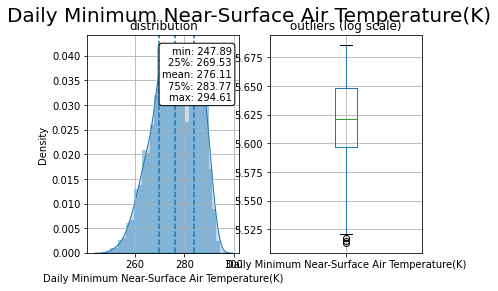

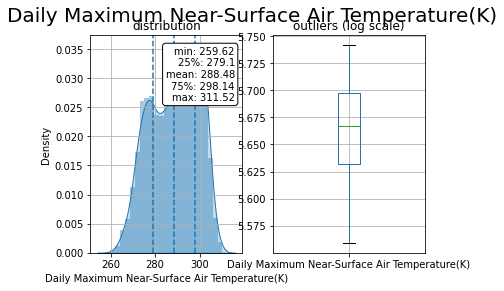

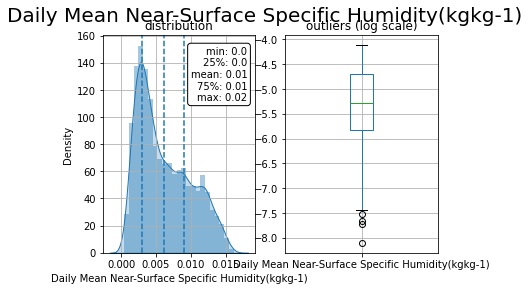

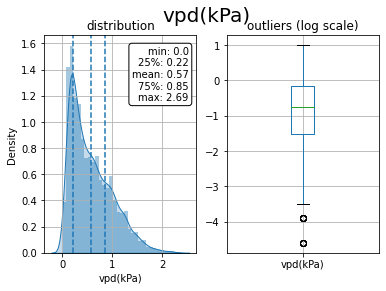

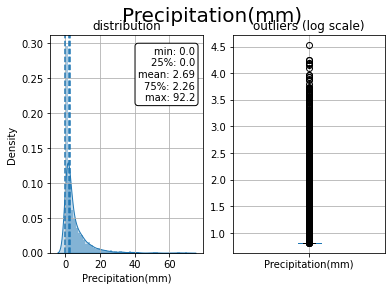

In [21]:
check_distribution_conti(df_his_daily, 'Daily Minimum Near-Surface Air Temperature(K)')
check_distribution_conti(df_his_daily, 'Daily Maximum Near-Surface Air Temperature(K)')
check_distribution_conti(df_his_daily, 'Daily Mean Near-Surface Specific Humidity(kgkg-1)')
check_distribution_conti(df_his_daily, 'vpd(kPa)')
check_distribution_conti(df_his_daily, 'Precipitation(mm)')


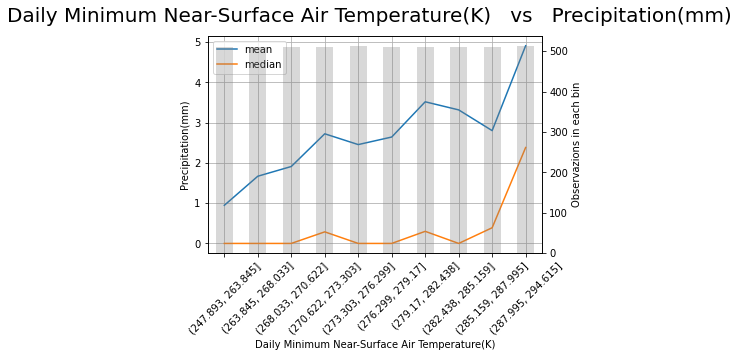

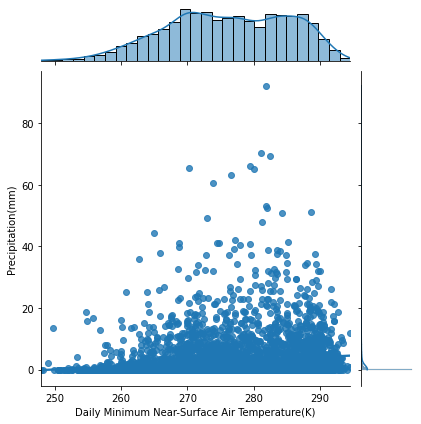

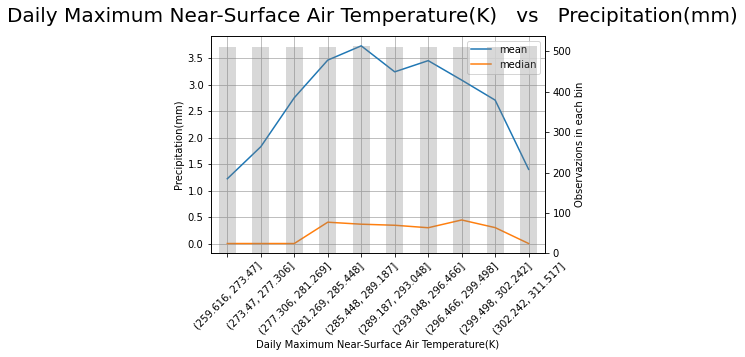

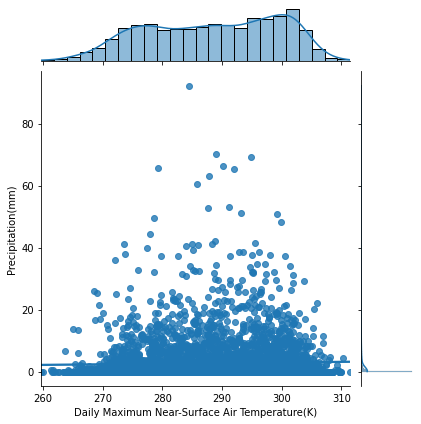

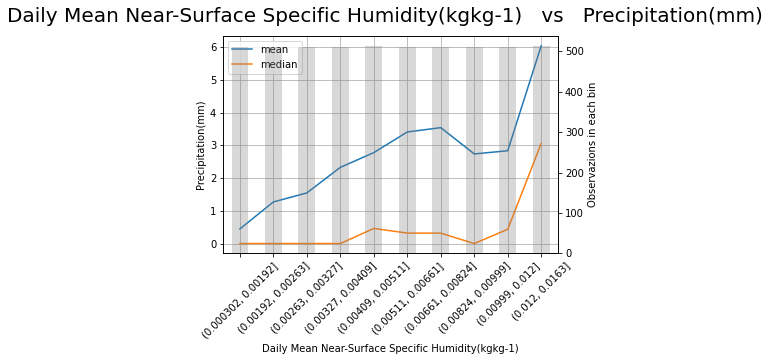

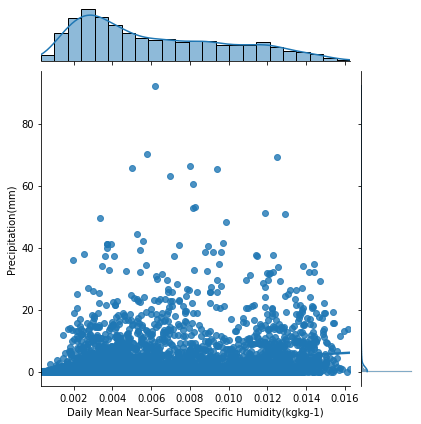

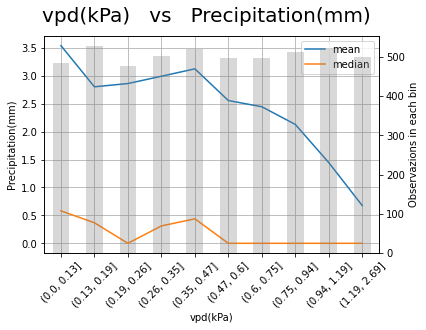

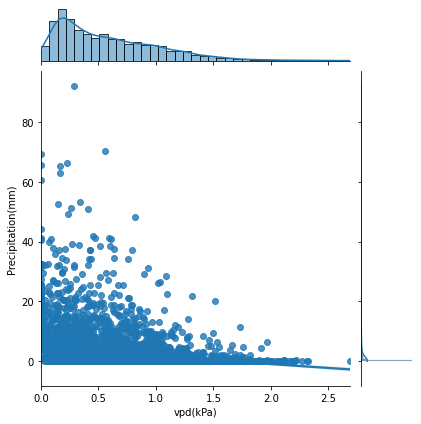

In [22]:
check_bivariant_num(df_his_daily, 'Daily Minimum Near-Surface Air Temperature(K)', 'Precipitation(mm)')
check_bivariant_num(df_his_daily, 'Daily Maximum Near-Surface Air Temperature(K)', 'Precipitation(mm)')
check_bivariant_num(df_his_daily, 'Daily Mean Near-Surface Specific Humidity(kgkg-1)', 'Precipitation(mm)')
check_bivariant_num(df_his_daily, 'vpd(kPa)', 'Precipitation(mm)')

In [23]:
#Select training set such that for every 7 days we will provide the next 1 days temperature as output

x_train = []
y_train = []
n_future = 1 # next 1 day temperature forecast
n_past = 7 # Past 7 days 
for i in range(0,len(training_set_scaled)-n_past-n_future+1):
    x_train.append(training_set_scaled[i : i + n_past , 0])     
    y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

In [24]:
x_train.shape

(5106, 7, 1)

In [25]:
y_train.shape

(5106, 1)

##Data Preprocessing and Model Building

###LSTM prediction model for Precipitation prediction
We will first build a LSTM prediction model for precipitation data.<br>
Importance of precipitation for climate prediction goes here...

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [28]:
dataset = df_his_precipitation['Precipitation(mm)']

In [29]:
dataset

0        1.098970
1        1.960552
2        8.333006
3        8.629661
4        0.496073
          ...    
5108    16.193007
5109     0.330193
5110     0.000000
5111     0.000000
5112     1.214768
Name: Precipitation(mm), Length: 5113, dtype: float64

In [36]:
train, test = dataset[:3580], dataset[3580:]

In [37]:
train

0        1.098970
1        1.960552
2        8.333006
3        8.629661
4        0.496073
          ...    
3575     0.000000
3576     0.000000
3577     0.364624
3578     3.631672
3579    20.993078
Name: Precipitation(mm), Length: 3580, dtype: float64

In [44]:
test

3580     0.895570
3581     0.860163
3582     1.148473
3583     0.542565
3584     0.000000
          ...    
5108    16.193007
5109     0.330193
5110     0.000000
5111     0.000000
5112     1.214768
Name: Precipitation(mm), Length: 1533, dtype: float64

In [51]:
x_train = []
y_train = []
n_future = 1 
n_past = 60 # Past 30 days 
for i in range(0,len(train)-n_past-n_future+1):
    x_train.append(train[i : i + n_past ])     
    y_train.append(train[i + n_past : i + n_past + n_future ])
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

In [52]:
x_train

array([[[1.09897 ],
        [1.960552],
        [8.333006],
        ...,
        [0.      ],
        [0.      ],
        [0.      ]],

       [[1.960552],
        [8.333006],
        [8.629661],
        ...,
        [0.      ],
        [0.      ],
        [0.981317]],

       [[8.333006],
        [8.629661],
        [0.496073],
        ...,
        [0.      ],
        [0.981317],
        [0.      ]],

       ...,

       [[9.324732],
        [3.021117],
        [0.      ],
        ...,
        [0.88023 ],
        [0.      ],
        [0.      ]],

       [[3.021117],
        [0.      ],
        [0.      ],
        ...,
        [0.      ],
        [0.      ],
        [0.364624]],

       [[0.      ],
        [0.      ],
        [0.      ],
        ...,
        [0.      ],
        [0.364624],
        [3.631672]]])

In [53]:
 y_train

array([[ 0.981317],
       [ 0.      ],
       [ 1.704284],
       ...,
       [ 0.364624],
       [ 3.631672],
       [20.993078]])

References:<br>
https://medium.com/analytics-vidhya/weather-forecasting-with-recurrent-neural-networks-1eaa057d70c3